DeepONet is a neural network architecture designed to learn operators (i.e., mappings between functions). It's particularly useful for solving partial differential equations (PDEs) where the input can be an entire function rather than a single value or vector.

# Setup and Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


torch.manual_seed(1)
np.random.seed(1)


# Data Generation for the 1D Diffusion Equation

In [ ]:
def generate_stiffness_matrix(num_points, L=1.0):
    dx = L / (num_points - 1)
    main_diag = 2.0 * np.ones(num_points)
    off_diag = -1.0 * np.ones(num_points - 1)

    K = diags([main_diag, off_diag, off_diag], [0, -1, 1]).tocsc()

    # Apply zero Dirichlet boundary conditions
    K = K / dx
    K[0, 0] = K[-1, -1] = 1.0
    K[0, 1] = K[-1, -2] = 0.0

    return K

def generate_load_vector(rhs, num_points, L=1.0):
    dx = L / (num_points - 1)
    F = rhs * dx
    F[0] = 0  # Zero Dirichlet boundary condition at x=0
    F[-1] = 0  # Zero Dirichlet boundary condition at x=L
    return F

def solve_diffusion(K, F):
    u = spsolve(K, F)
    return u

def generate_diffusion_data(num_samples, num_points, L=1.0):
    """
    Generate data for the 1D diffusion equation with varying right-hand side functions.

    Args:
        num_samples (int): Number of samples to generate.
        num_points (int): Number of spatial points.
        L (float): Length of the domain.

    Returns:
        x (torch.Tensor): Spatial coordinates.
        rhs (torch.Tensor): Right-hand side functions.
        solutions (torch.Tensor): Corresponding solutions.
    """
    x = np.linspace(0, L, num_points)
    x = torch.tensor(x, dtype=torch.float32).to(device)

    K = generate_stiffness_matrix(num_points, L)

    rhs_list = []
    solutions_list = []

    def generate_grf_function_1D(sigma_0, l_0, num_of_samples, dofs):

        num_of_elements = dofs-1

        if len(sigma_0) != len(l_0):
            raise ValueError('Size of sigma_0 and l_0 mismatch')
        x_grid = np.linspace(0, 1, num_of_elements + 1)
        x_distances = x_grid.transpose() - np.expand_dims(x_grid, -1)
        covariance_matrix = np.zeros((num_of_elements + 1, num_of_elements + 1))
        for mode_index, corr_length in enumerate(l_0):
            covariance_matrix = \
                covariance_matrix + ((sigma_0[mode_index] ** 2) *
                                     np.exp(- 0.5 / (corr_length ** 2) *
                                                   (x_distances ** 2)))
        mu = np.zeros_like(x_grid)
        return np.random.multivariate_normal(mu, covariance_matrix, num_of_samples)

    rhss = generate_grf_function_1D([0.1], [0.3], num_samples, num_points)

    for i in range(num_samples):
        coeffs = np.random.randn(3)  # Random coefficients for smoothness
        # rhs = (
        #     coeffs[0] * np.sin(0.1 * np.pi * x) +
        #     coeffs[1] * np.cos(0.5 * np.pi * x) +
        #     coeffs[2] * np.sin(np.pi * x)
        # )

        rhs = rhss[i]

        F = generate_load_vector(rhs, num_points, L)
        u = solve_diffusion(K, F)

        rhs_list.append(torch.tensor(rhs, dtype=torch.float32).to(device))
        solutions_list.append(torch.tensor(u, dtype=torch.float32).to(device))

    rhs = torch.stack(rhs_list)
    solutions = torch.stack(solutions_list)

    return x, rhs, solutions


# DeepONet Architecture

In [ ]:
class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, num_basis, hidden_dim):
        super(DeepONet, self).__init__()
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_basis)
        )
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_basis),
            nn.Tanh()
        )


    def forward(self, x_branch, x_trunk):
        branch_output = self.branch_net(x_branch)
        trunk_output = self.trunk_net(x_trunk)

        trunk_output   = trunk_output.T * x_trunk[:,0] * (x_trunk[:,0] - 1.0)

        output = (branch_output @ trunk_output)


        return output


# Training the Model

In [ ]:
def train_deeponet(model, x, rhs, solutions, num_epochs=20000, learning_rate=0.0001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        outputs = []
        branch_input = rhs
        trunk_input = x.unsqueeze(1)

        output = model(branch_input, trunk_input)
        outputs.append(output)

        outputs = torch.stack(outputs).squeeze()


        loss = criterion(outputs, solutions)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.9e}')


# Evaluation

In [ ]:
def evaluate_deeponet(model, x, rhs):
    model.eval()
    with torch.no_grad():
        outputs = []
        branch_input = rhs
        trunk_input = x.unsqueeze(1)
        output = model(branch_input, trunk_input)
        outputs.append(output)

        outputs = torch.stack(outputs).squeeze()
    return outputs

# Plot results

In [ ]:
def plot_results(x, true_solutions, predicted_solutions):
    for i in range(min(5, true_solutions.shape[0])):
        plt.plot(x.cpu().numpy(), true_solutions[i].cpu().numpy(), label='True Solution')
        plt.plot(x.cpu().numpy(), predicted_solutions[i].cpu().numpy(), label='Predicted Solution', linestyle='--')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.legend()
        plt.show()

In [ ]:
def plot_data(x, rhs, solutions, num_samples_to_plot=5):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    for i in range(min(num_samples_to_plot, rhs.shape[0])):

        axs[0].plot(x.cpu().numpy(), rhs[i].cpu().numpy(), label=f'RHS {i+1}')
        axs[0].set_xlabel('x')
        axs[0].set_ylabel('rhs(x)')
        axs[0].set_title(f'Right-Hand Side Function')
        axs[0].legend()

        axs[1].plot(x.cpu().numpy(), solutions[i].cpu().numpy(), label=f'Solution  {i+1}')
        axs[1].set_xlabel('x')
        axs[1].set_ylabel('u(x)')
        axs[1].set_title(f'Solution')
        axs[1].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Main
num_samples = 3000
num_collocation_points = 50

# Generate training data
x, rhs, solutions = generate_diffusion_data(num_samples, num_collocation_points)

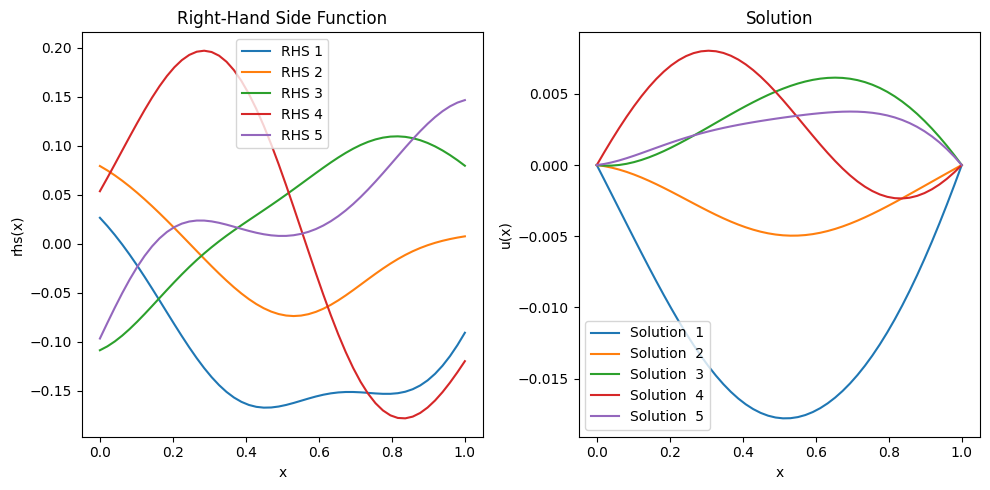

In [ ]:
plot_data(x, rhs, solutions, num_samples_to_plot=5)

In [ ]:
# Initialize and train the model
model = DeepONet(branch_input_dim=num_collocation_points, trunk_input_dim=1, hidden_dim=50, num_basis = 120).to(device)


In [ ]:
train_deeponet(model, x, rhs, solutions, num_epochs=5000, learning_rate=1e-4)

Epoch [100/5000], Loss: 4.811765280e-07
Epoch [200/5000], Loss: 2.240878842e-07
Epoch [300/5000], Loss: 1.815911901e-07
Epoch [400/5000], Loss: 1.545122075e-07
Epoch [500/5000], Loss: 1.360162543e-07
Epoch [600/5000], Loss: 1.235184044e-07
Epoch [700/5000], Loss: 1.150471931e-07
Epoch [800/5000], Loss: 1.092500597e-07
Epoch [900/5000], Loss: 1.052193355e-07
Epoch [1000/5000], Loss: 1.023298282e-07
Epoch [1100/5000], Loss: 1.001478083e-07
Epoch [1200/5000], Loss: 9.837980031e-08
Epoch [1300/5000], Loss: 9.683479618e-08
Epoch [1400/5000], Loss: 9.539442658e-08
Epoch [1500/5000], Loss: 9.398654299e-08
Epoch [1600/5000], Loss: 9.256851996e-08
Epoch [1700/5000], Loss: 9.111391819e-08
Epoch [1800/5000], Loss: 8.960591913e-08
Epoch [1900/5000], Loss: 8.803267804e-08
Epoch [2000/5000], Loss: 8.638541260e-08
Epoch [2100/5000], Loss: 8.465686108e-08
Epoch [2200/5000], Loss: 8.284027331e-08
Epoch [2300/5000], Loss: 8.092948178e-08
Epoch [2400/5000], Loss: 7.891842557e-08
Epoch [2500/5000], Loss: 

In [ ]:
predicted_solutions = evaluate_deeponet(model, x, rhs)
predicted_solutions.shape

torch.Size([3000, 50])

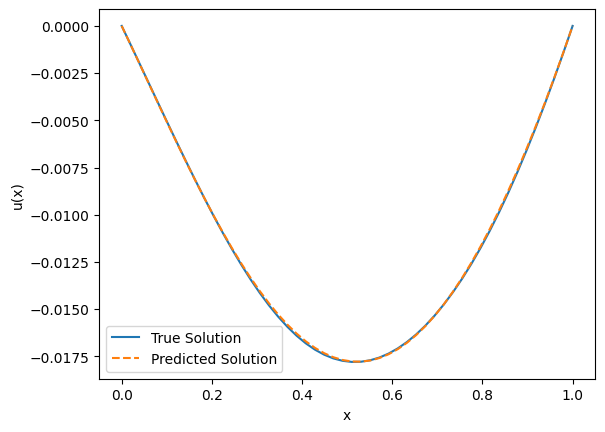

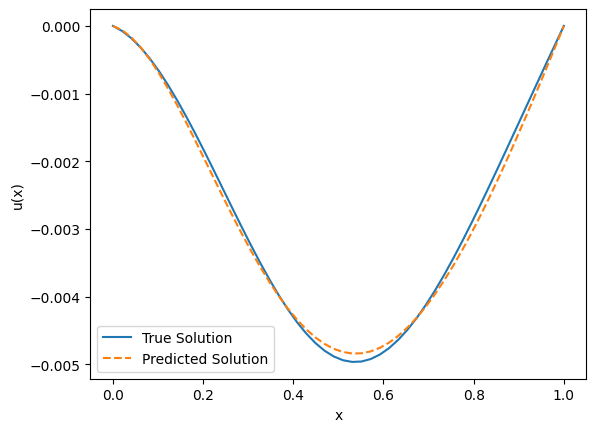

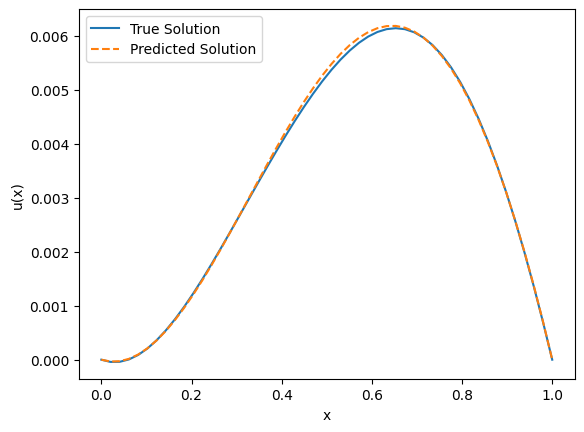

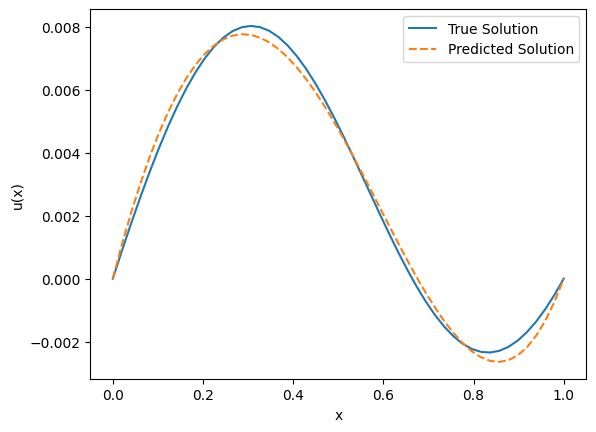

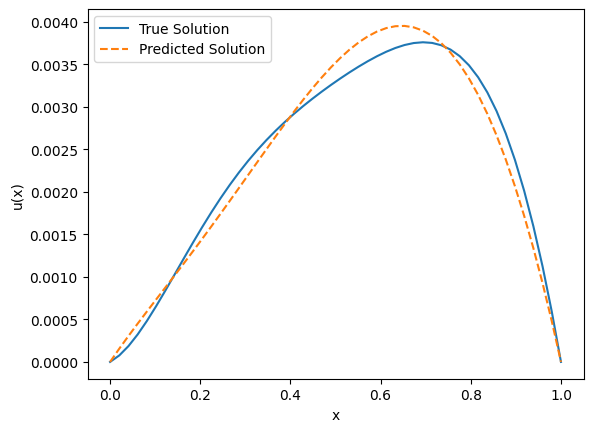

In [ ]:
# Plot results
plot_results(x, solutions, predicted_solutions)

In [ ]:
# Generate testing data
num_test_samples = 10
num_test_collocation_points = 200

x_DON = x
x_test, rhs_test, solutions_test = generate_diffusion_data(num_test_samples, num_test_collocation_points)

# print("x_DON ", x_DON.shape)
# print("x_test ", x_test.shape)
# print("rhs_test ", rhs_test.shape)

sample_id = 1

rhs_test_sample = rhs_test[sample_id, :].detach().numpy()
x_test_sample = x_test.detach().numpy()
x_DON_sample = x_DON.detach().numpy()

# print("x_DON ", rhs_test_sample.shape)
# print("x_test ", x_test_sample.shape)
# print("rhs_test ", x_DON_sample.shape)


rhs_DON = np.interp(x_DON_sample,  rhs_test_sample, x_test_sample)

# print("rhs_DON ", rhs_DON.shape)
rhs_DON = torch.tensor(rhs_DON, dtype=torch.float32)


# Evaluate the model
predicted_solutions = evaluate_deeponet(model, x_test, rhs_DON)
predicted_solutions.shape






In [ ]:
# Plot results
# print("solutions_test[sample_id] ", solutions_test[sample_id])
# print("predicted_solutions ", predicted_solutions)

plt.plot(x_test.cpu().numpy(), solutions_test[sample_id].cpu().numpy(), label='True Solution')
plt.plot(x_test.cpu().numpy(), predicted_solutions.cpu().numpy(), label='Predicted Solution', linestyle='--')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()


# plot_results(x_test, solutions_test[sample_id], predicted_solutions)